In [2]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import rstoolbox
import pandas as pd
import seaborn as sns
import numpy as np
import copy

sns.set(font_scale=1.5)


# Scaffold Adaptability to Binder Clash


In this example, the insertion of the BCL-2-like protein 11's binding motif to the early antigen protein R ([2WH6](http://www.rcsb.org/pdb/explore/explore.do?structureId=2wh6)) into the scaffold of the designed protein 4E10_D0_1ISEA_004_N ([3LHP](http://www.rcsb.org/pdb/explore/explore.do?structureId=3lhp)) would produce a design that will clash with the binder.  
By using a structure of a computationally designed inhibitor of an Epstein-Barr viral Bcl-2 protein ([4OYD](http://www.rcsb.org/pdb/explore/explore.do?structureId=4oyd)) as a target structure, we will see if folding the design in the presence of the binder will recuperate its 3D configuration (by shifting the correlative disposition of the alpha helices). The reference point has been calculated with a [script](bcl2/3lhp_vs_4oyd_alignment.xml) that [determined](bcl2/3lhp_vs_4oyd) a __global RMSD__ of __1.605__ and a __local RMSD__ (aligned through the insertion region) of __2.351__. The structure file [3lhp_vs_4oyd.pdb](bcl2/3lhp_vs_4oyd.pdb) shows the alignemnt that generated such value when loaded in _PyMOL_ with [4oyd](bcl2/pdbs/4oyd.pdb.gz).


|template|target|
|:------:|:------:|
|![template](bcl2/images/min_rms2target_templateonly.png)|![target](bcl2/images/min_rms2target_targetonly.png)|  



In [6]:
dlistT2T = rstoolbox.api.read_rosetta_silent("bcl2/3lhp_vs_4oyd", "t2t")
definition = {
    "scores":{
        "description": "description", "design_type": "type", "total_score": "score",
        "GlobalHRMSD": "GlobalHRMSD", "LocalHRMSD": "LocalHRMSD"
    }
}
dfT2T = rstoolbox.api.process_from_definitions(dlistT2T, definition)
dfT2T

,GlobalHRMSD,LocalHRMSD,description,score,type
0,1.605,2.351,3lhp_0001,1398.407,t2t


## Round 2

_(Round one was preparatory)_

We perform 6 different tests:  

||no binder|binder|
|:------:|:------:|:------:|
|no constraints|[xml](bcl2/nocst.nobinder.xml)|[xml](bcl2/nocst.binder.xml)|
|sse constraints|[xml](bcl2/ssecst.nobinder.xml)|[xml](bcl2/ssecst.binder.xml)|
|full constraints|[xml](bcl2/fullcst.nobinder.xml)|[xml](bcl2/fullcst.binder.xml)|

All the experiment outputs performed in this round (labeled as __round 2__), are placed into folders with the `{constraint_condition}` name and named as follows:  
```
bcl2_{constraint_condition}_{binder_condition}_2_{ID}.gz
bcl2_{constraint_condition}_{binder_condition}_2_minisilent.gz
```  
The `minisilent` file will not work in Rosetta, but it is optimized to use with the [RosettaSilentToolBox python library](https://github.com/jaumebonet/RosettaSilentToolbox).

In [5]:
def merge_rmsd_types( df, keys ):
    dataframes = []
    for k in keys["split"]:
        colIDs = copy.copy(keys["keep"])
        colIDs.append(k[0])
        wdf = df[colIDs]
        wdf = wdf.assign(temporarykey1=pd.Series([k[1]]*len(wdf[colIDs[0]])).values).copy(True)
        wdf = wdf.rename(index=str, columns={
            k[0]: keys["names"][0],
            "temporarykey1": keys["names"][1]
        })
        if ( len(k) > 2 ):
            wdf = wdf.assign(temporarykey2=pd.Series([k[2]]*len(wdf[colIDs[0]])).values).copy(True)
            wdf = wdf.rename(index=str, columns={
                "temporarykey2": keys["names"][2]
            })
        dataframes.append(wdf)
    return pd.concat(dataframes)

In [6]:
experiments = [
    ("nocst",   "nobinder", "bcl2/nocst/bcl2_nocst_nobinder_2_minisilent.gz"),
    ("nocst",   "binder",   "bcl2/nocst/bcl2_nocst_binder_2_minisilent.gz"),
    ("ssecst",  "nobinder", "bcl2/ssecst/bcl2_ssecst_nobinder_2_minisilent.gz"),
    ("ssecst",  "binder",   "bcl2/ssecst/bcl2_ssecst_binder_2_minisilent.gz"),
    ("fullcst", "nobinder", "bcl2/fullcst/bcl2_fullcst_nobinder_2_minisilent.gz"),
    ("fullcst", "binder",   "bcl2/fullcst/bcl2_fullcst_binder_2_minisilent.gz")
]
selector_nobinder = {
    "scores":{
        "description": "description", "design_type": "type", "score": "score", "GRMSD2Target": "GRMSD2Target",
        "GRMSD2Template": "GRMSD2Template", "LHRMSD2Target": "LHRMSD2Target", "LRMSD2Target": "LRMSD2Target"
    }
}
selector_binder = {
    "scores":{
        "description": "description", "design_type": "type", "design_score": "score", "GRMSD2Target": "GRMSD2Target",
        "GRMSD2Template": "GRMSD2Template", "LHRMSD2Target": "LHRMSD2Target", "LRMSD2Target": "LRMSD2Target"
    }
}
logic = {
    "keep": ["description", "type", "score", "condition"],
    "split": [("GRMSD2Target", "global", "target"), ("GRMSD2Template", "global", "template"),
              ("LHRMSD2Target", "hlocal", "target"), ("LRMSD2Target", "local", "target") ],
    "names": ["rmsd", "rmsd_type", "rmsd_to"]
}
dataframes     = []
plotdataframes = []
for experiment in experiments:
    dlist      = rstoolbox.api.read_rosetta_silent(experiment[2], experiment[0])
    definition = selector_nobinder if experiment[1] == "nobinder" else selector_binder
    df         = rstoolbox.api.process_from_definitions(dlist, definition)
    df = df.assign(condition=pd.Series([experiment[1]]*len(df["type"])).values)
    dataframes.append(df)
    plotdataframes.append(merge_rmsd_types( df, logic ))
    
data  = pd.concat(dataframes)
pdata = pd.concat(plotdataframes) 

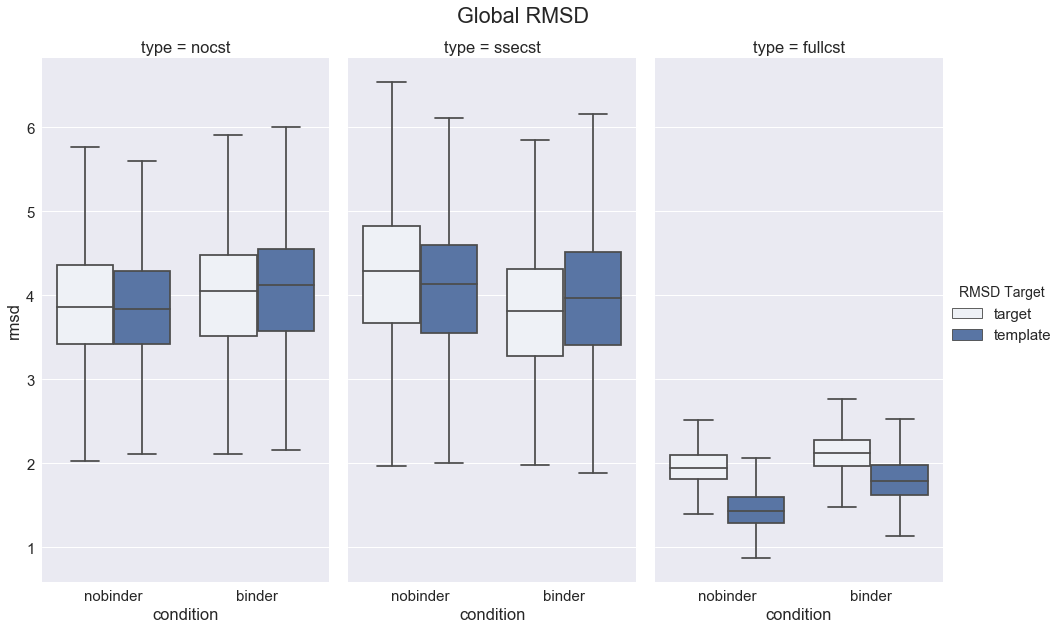

In [7]:
g = sns.FacetGrid(pdata[(pdata["rmsd_type"] == "global")], col="type", size=9, aspect=0.5)
(g.map(sns.boxplot, "condition", "rmsd", "rmsd_to", showfliers=False)
 .despine(left=True).add_legend(title="RMSD Target"))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Global RMSD')
sns.plt.show()

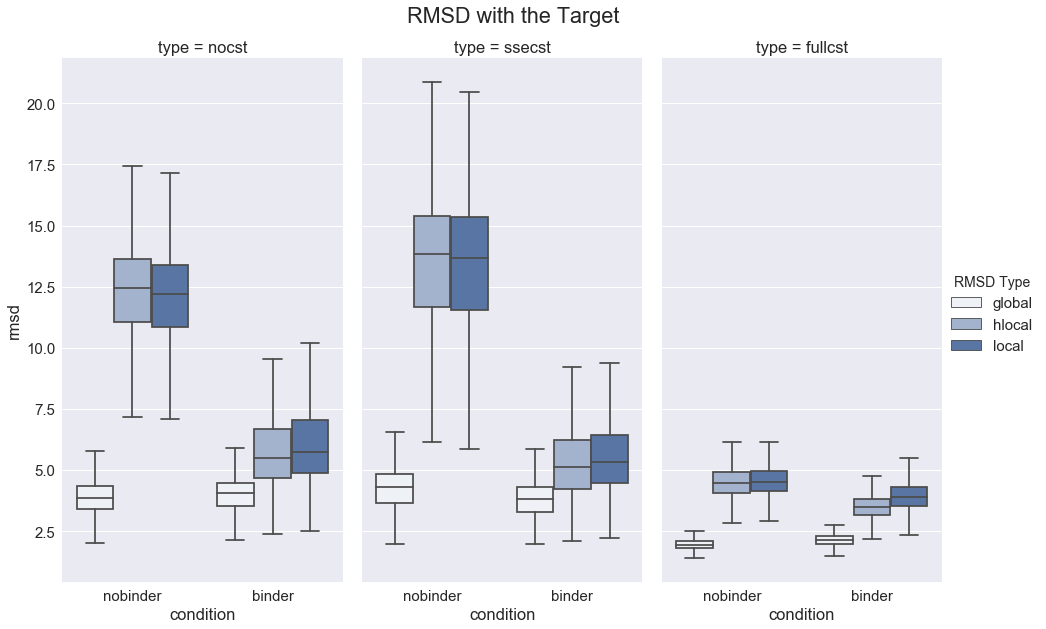

In [8]:
g = sns.FacetGrid(pdata[(pdata["rmsd_to"] == "target")], col="type", size=9, aspect=0.5)
(g.map(sns.boxplot, "condition", "rmsd", "rmsd_type", showfliers=False)
 .despine(left=True).add_legend(title="RMSD Type"))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('RMSD with the Target')
sns.plt.show()

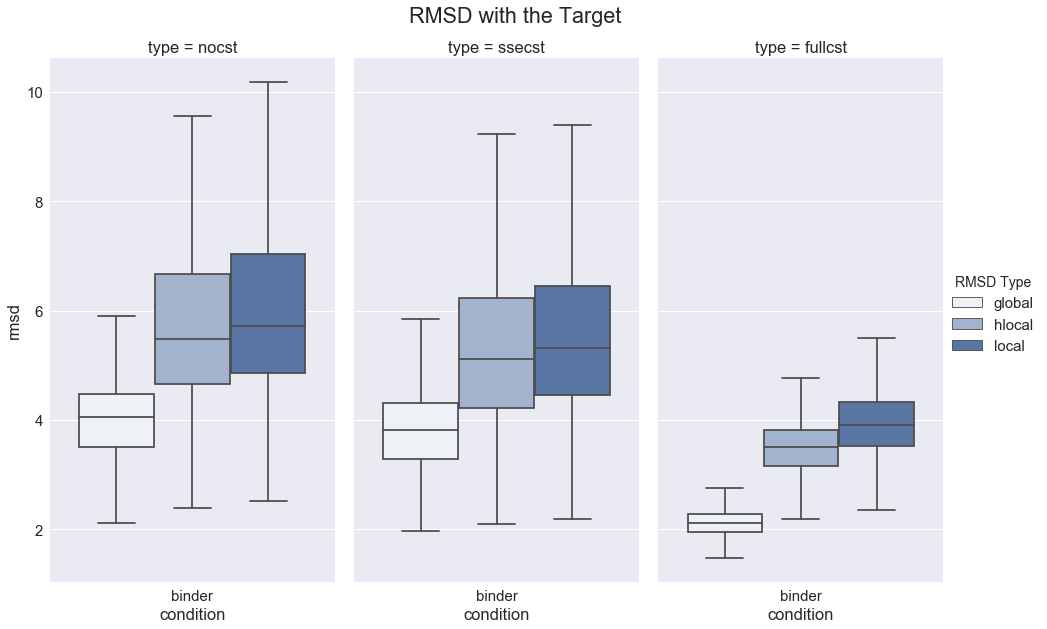

In [9]:
g = sns.FacetGrid(pdata[(pdata["rmsd_to"] == "target") & (pdata["condition"] == "binder")],
                  col="type", size=9, aspect=0.5)
(g.map(sns.boxplot, "condition", "rmsd", "rmsd_type", showfliers=False)
 .despine(left=True).add_legend(title="RMSD Type"))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('RMSD with the Target')
sns.plt.show()

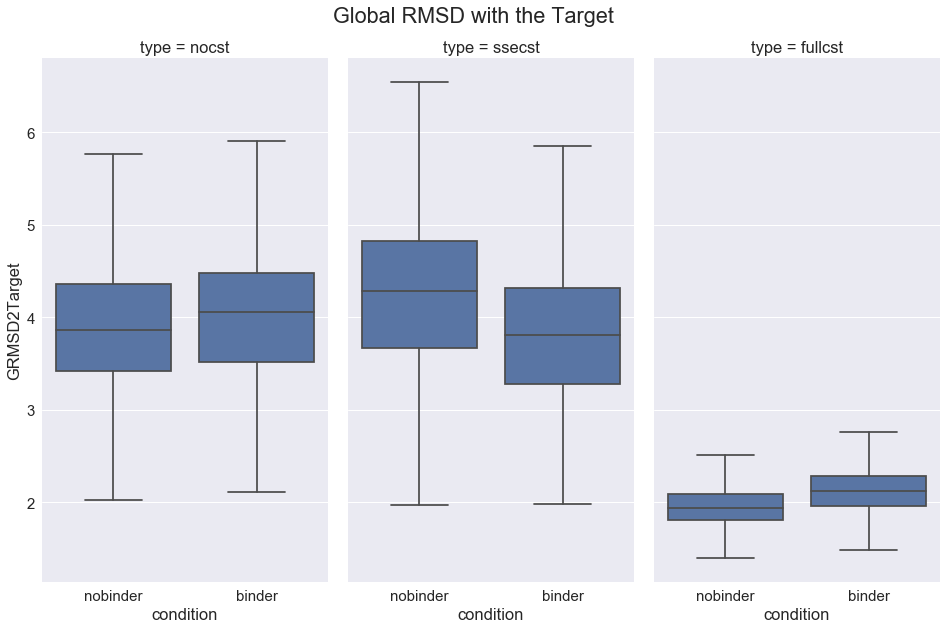

In [10]:
g = sns.FacetGrid(data, col="type", size=9, aspect=0.5)
g = g.map(sns.boxplot, "condition", "GRMSD2Target", showfliers=False)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Global RMSD with the Target')
sns.plt.show()

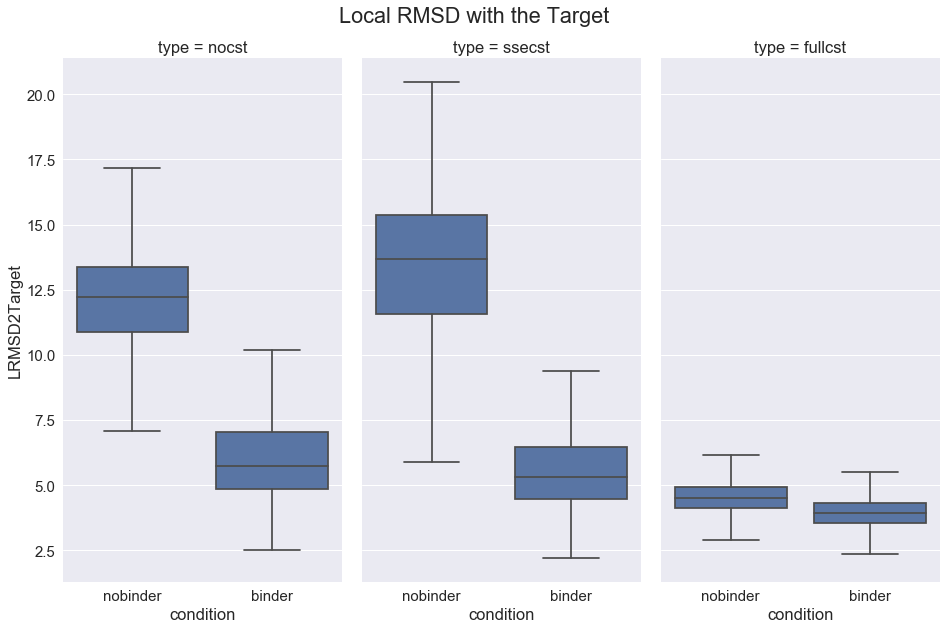

In [11]:
g = sns.FacetGrid(data, col="type", size=9, aspect=0.5)
g = g.map(sns.boxplot, "condition", "LRMSD2Target", showfliers=False)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Local RMSD with the Target')
sns.plt.show()

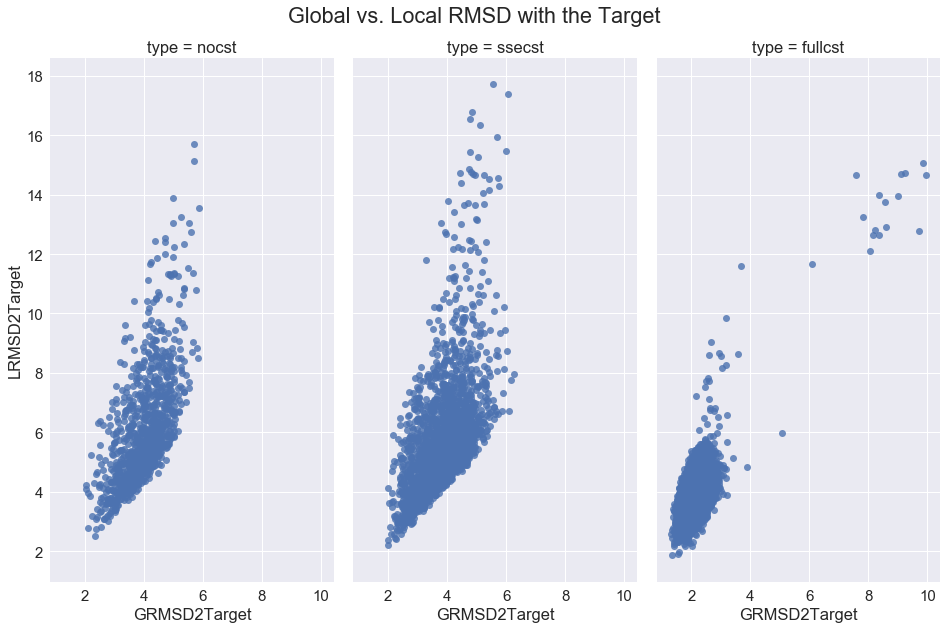

In [12]:
binderdata = data[(data["condition"] == "binder") & (data["LRMSD2Target"] < 20) & (data["GRMSD2Target"] < 10)]
g = sns.FacetGrid(binderdata, col="type", size=9, aspect=0.5)
g = g.map(sns.regplot, "GRMSD2Target", "LRMSD2Target", fit_reg=False)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Global vs. Local RMSD with the Target')
sns.plt.show()

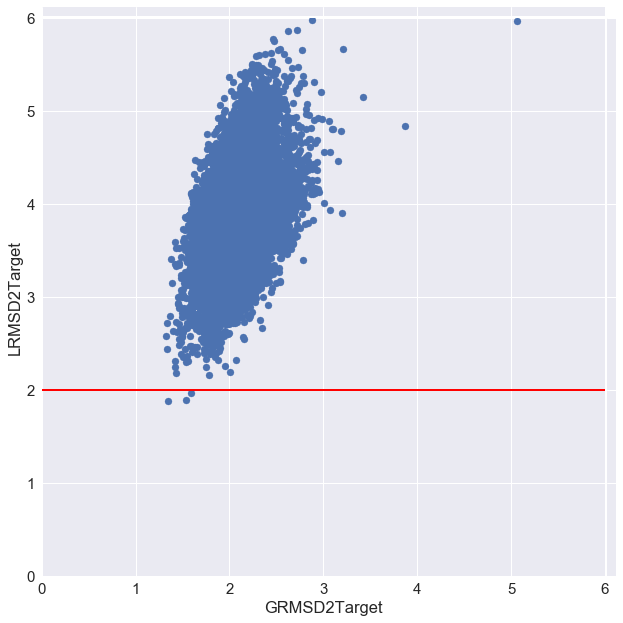

In [13]:
# Let's setup a selection of decoys on the fullcst.binder dataset
fullcstbinderdata = data[(data["condition"] == "binder") & (data["type"] == "fullcst")]
max_display_limit = 6
#               X  y
sele_line_p1 = [0, 2]
sele_line_p2 = [7, 2]
selection_line = [
    [sele_line_p1[0], sele_line_p2[0]],
    [sele_line_p1[1], sele_line_p2[1]]
]
grid = sns.JointGrid("GRMSD2Target", "LRMSD2Target", data=fullcstbinderdata,
                     xlim=(0,max_display_limit), ylim=(0,max_display_limit), size=9, ratio=50)
grid.plot_joint(plt.scatter)
plt.plot(selection_line[0], selection_line[1], linewidth=2, color="red")
sns.plt.show()

In [14]:
top_rmsd_selection = 2.01
selected_data = data[(data["condition"] == "binder") & (data["type"] == "fullcst") &
                     (data["LRMSD2Target"] < top_rmsd_selection) & (data["GRMSD2Target"] < top_rmsd_selection) ]
selected_data

,GRMSD2Target,GRMSD2Template,LHRMSD2Target,LRMSD2Target,description,score,type,condition
4462,1.542,1.675,1.705,1.893,bcl2_3lhp_fullcst_binder_2_19298_0444,-239.660,fullcst,binder
5278,1.341,1.234,1.689,1.876,bcl2_3lhp_fullcst_binder_2_23679_0270,-243.788,fullcst,binder
8576,1.590,1.630,1.707,1.961,bcl2_3lhp_fullcst_binder_2_27612_0578,-226.307,fullcst,binder


In [15]:
top_rmsd_selection_limit = 2
lineardata = [
    go.Parcoords(
        line = dict(color = 'blue'),
        dimensions = list([
            dict(range = [min(selected_data['score']), min(max(selected_data['score']),0)],
                label = 'Score', values = selected_data['score']),
            dict(range = [0,top_rmsd_selection_limit],
                label = 'RMSD2Template', values = selected_data['GRMSD2Template']),
            dict(range = [0,top_rmsd_selection_limit],
                label = 'RMSD2Target', values = selected_data['GRMSD2Target']),
            dict(range = [0,top_rmsd_selection_limit],
                label = 'Local RMSD2Target', values = selected_data['LRMSD2Target']),
            dict(range = [0,top_rmsd_selection_limit],
                label = 'Local RMSD2Target (helix)', values = selected_data['LHRMSD2Target'])
            
        ])
    )
]
plotly.offline.iplot(lineardata)

### Comments

The 3 selected decoys can be found in the [selected_round2](bcl/selected_round2) folder.  
The observation is that the relative position between the binding motif and the target in 2WH6 and 4OYD is slighly changed and might be affecting the achievement of the expected configuration.    

## Round 3

Thus, we will try to insert the motif directly from 4OYD using its own binder. In this case, we will only run two scenarios:

||binder|
|:------:|:------:|
|sse constraints|[xml](bcl2/ssecst.binder_from4oyd.xml)|
|full constraints|[xml](bcl2/fullcst.binder_from4oyd.xml)|



In [16]:
experiments = [
    ("ssecst",  "binder", "bcl2/ssecst/bcl2_ssecst_binder_from4oyd_3_minisilent.gz"),
    ("fullcst", "binder", "bcl2/fullcst/bcl2_fullcst_binder_from4oyd_3_minisilent.gz")
]
definition = {
    "scores":{
        "description": "description", "design_type": "type", "design_score": "score", "GRMSD2Target": "GRMSD2Target",
        "GRMSD2Template": "GRMSD2Template", "LHRMSD2Target": "LHRMSD2Target", "LRMSD2Target": "LRMSD2Target"
    }
}
logic = {
    "keep": ["description", "type", "score", "condition"],
    "split": [("GRMSD2Target", "global", "target"), ("GRMSD2Template", "global", "template"),
              ("LHRMSD2Target", "hlocal", "target"), ("LRMSD2Target", "local", "target") ],
    "names": ["rmsd", "rmsd_type", "rmsd_to"]
}
dataframes     = []
plotdataframes = []
for experiment in experiments:
    dlist      = rstoolbox.api.read_rosetta_silent(experiment[2], experiment[0])
    df         = rstoolbox.api.process_from_definitions(dlist, definition)
    df = df.assign(condition=pd.Series([experiment[1]]*len(df["type"])).values)
    dataframes.append(df)
    plotdataframes.append(merge_rmsd_types( df, logic ))
    
datar3  = pd.concat(dataframes)
pdatar3 = pd.concat(plotdataframes) 

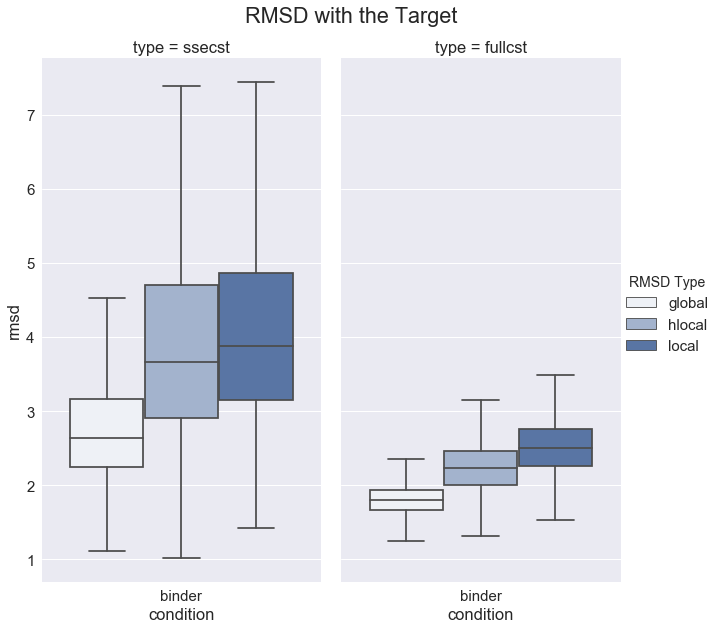

In [17]:
g = sns.FacetGrid(pdatar3[(pdatar3["rmsd_to"] == "target")], col="type", size=9, aspect=0.5)
(g.map(sns.boxplot, "condition", "rmsd", "rmsd_type",)
 .despine(left=True).add_legend(title="RMSD Type"))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('RMSD with the Target')
sns.plt.show()

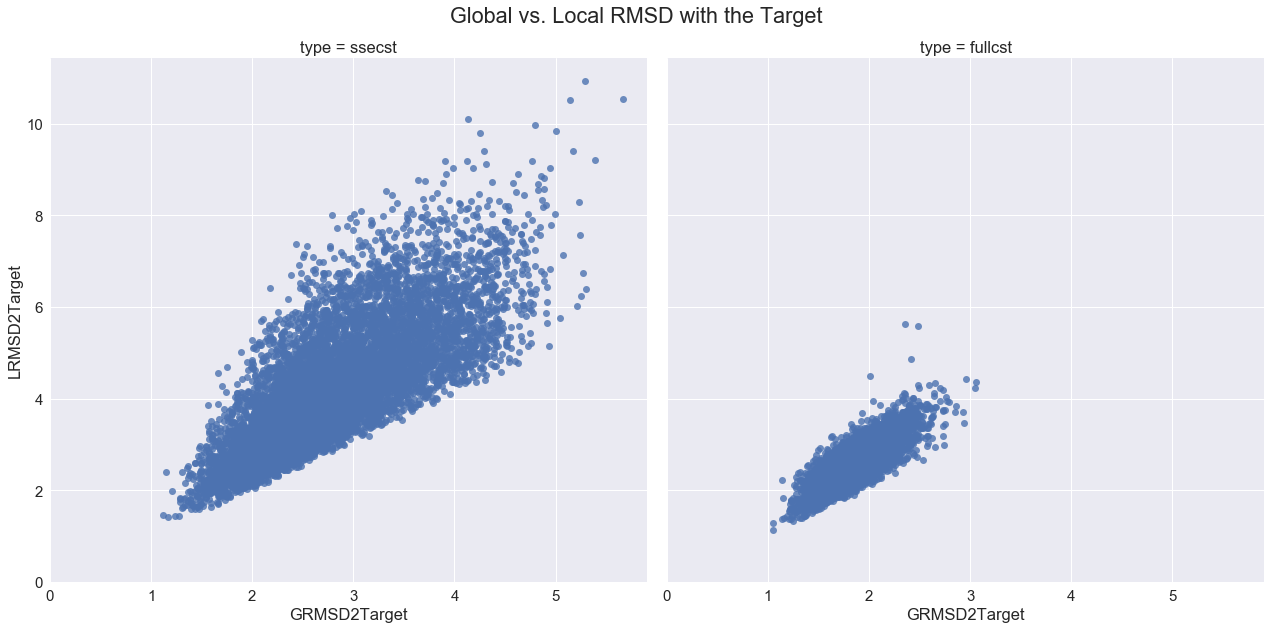

In [18]:
binderdatar3 = datar3[(datar3["condition"] == "binder")]
g = sns.FacetGrid(binderdatar3, col="type", size=9)
g = g.map(sns.regplot, "GRMSD2Target", "LRMSD2Target", fit_reg=False)
plt.subplots_adjust(top=0.9)
g.axes[0,0].set_ylim(0,)
g.axes[0,0].set_xlim(0,)
g.axes[0,1].set_ylim(0,)
g.axes[0,1].set_xlim(0,)
g.fig.suptitle('Global vs. Local RMSD with the Target')
sns.plt.show()

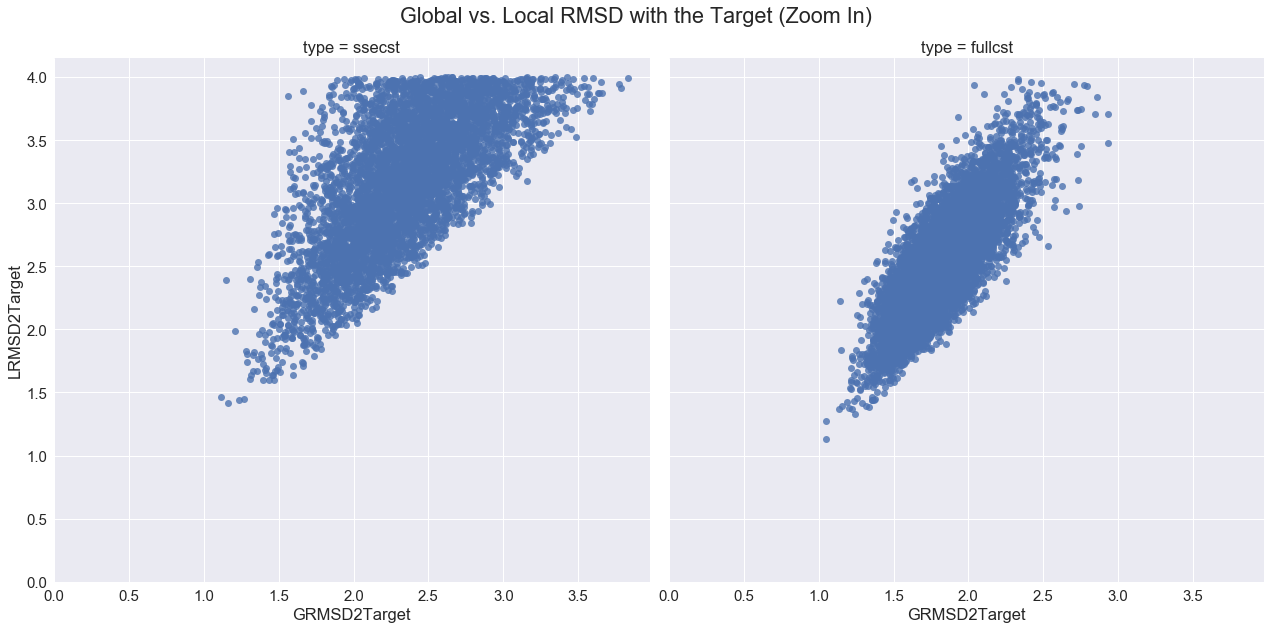

In [19]:
binderdatar3 = datar3[(datar3["condition"] == "binder")
                      & (datar3["LRMSD2Target"] < 4) & (datar3["GRMSD2Target"] < 4)]
g = sns.FacetGrid(binderdatar3, col="type", size=9)
g = g.map(sns.regplot, "GRMSD2Target", "LRMSD2Target", fit_reg=False)
plt.subplots_adjust(top=0.9)
g.axes[0,0].set_ylim(0,)
g.axes[0,0].set_xlim(0,)
g.axes[0,1].set_ylim(0,)
g.axes[0,1].set_xlim(0,)
g.fig.suptitle('Global vs. Local RMSD with the Target (Zoom In)')
sns.plt.show()

In [9]:
experiments = [
    ("ssecst",  "binder", "bcl2/ssecst/bcl2_ssecst_binder_from4oyd_nodesign_4_minisilent.gz"),
    ("fullcst", "binder", "bcl2/fullcst/bcl2_fullcst_binder_from4oyd_nodesign_4_minisilent.gz")
]
definition = {
    "scores":{
        "description": "description", "design_type": "type", "design_score": "score", "GRMSD2Target": "GRMSD2Target",
        "GRMSD2Template": "GRMSD2Template", "LHRMSD2Target": "LHRMSD2Target", "LRMSD2Target": "LRMSD2Target"
    }
}
logic = {
    "keep": ["description", "type", "score", "condition"],
    "split": [("GRMSD2Target", "global", "target"), ("GRMSD2Template", "global", "template"),
              ("LHRMSD2Target", "hlocal", "target"), ("LRMSD2Target", "local", "target") ],
    "names": ["rmsd", "rmsd_type", "rmsd_to"]
}
dataframes     = []
plotdataframes = []
for experiment in experiments:
    dlist      = rstoolbox.api.read_rosetta_silent(experiment[2], experiment[0])
    df         = rstoolbox.api.process_from_definitions(dlist, definition)
    df = df.assign(condition=pd.Series([experiment[1]]*len(df["type"])).values)
    dataframes.append(df)
    plotdataframes.append(merge_rmsd_types( df, logic ))
    
dataND  = pd.concat(dataframes)
pdataND = pd.concat(plotdataframes) 

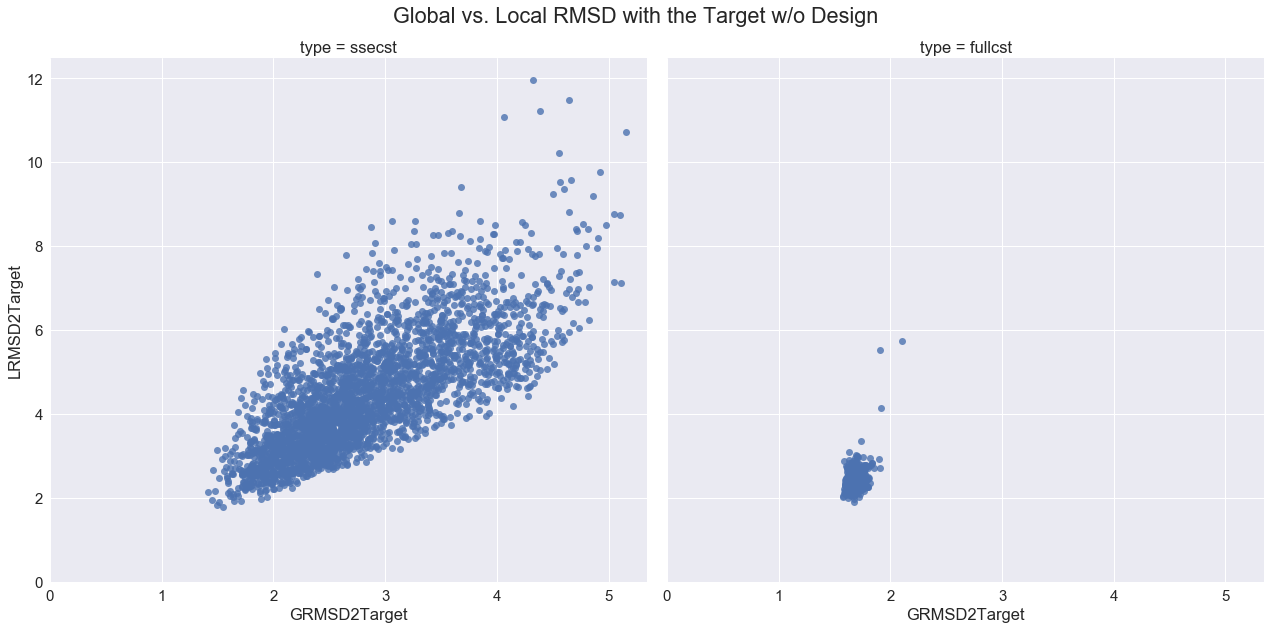

In [10]:
binderdataND = dataND[(dataND["condition"] == "binder")]
g = sns.FacetGrid(binderdataND, col="type", size=9)
g = g.map(sns.regplot, "GRMSD2Target", "LRMSD2Target", fit_reg=False)
plt.subplots_adjust(top=0.9)
g.axes[0,0].set_ylim(0,)
g.axes[0,0].set_xlim(0,)
g.axes[0,1].set_ylim(0,)
g.axes[0,1].set_xlim(0,)
g.fig.suptitle('Global vs. Local RMSD with the Target w/o Design')
sns.plt.show()

In [11]:
experiments = [
    ("fullcst", "binder", "bcl2/fullcst/bcl2_fullcst_binder_from4oyd_minimize_5_minisilent.gz")
]
definition = {
    "scores":{
        "description": "description", "design_type": "type", "design_score": "score", "GRMSD2Target": "GRMSD2Target",
        "GRMSD2Template": "GRMSD2Template", "LHRMSD2Target": "LHRMSD2Target", "LRMSD2Target": "LRMSD2Target"
    }
}
logic = {
    "keep": ["description", "type", "score", "condition"],
    "split": [("GRMSD2Target", "global", "target"), ("GRMSD2Template", "global", "template"),
              ("LHRMSD2Target", "hlocal", "target"), ("LRMSD2Target", "local", "target") ],
    "names": ["rmsd", "rmsd_type", "rmsd_to"]
}
dataframes     = []
plotdataframes = []
for experiment in experiments:
    dlist      = rstoolbox.api.read_rosetta_silent(experiment[2], experiment[0])
    df         = rstoolbox.api.process_from_definitions(dlist, definition)
    df = df.assign(condition=pd.Series([experiment[1]]*len(df["type"])).values)
    dataframes.append(df)
    plotdataframes.append(merge_rmsd_types( df, logic ))
    
dataMIN  = pd.concat(dataframes)
pdataMIN = pd.concat(plotdataframes) 

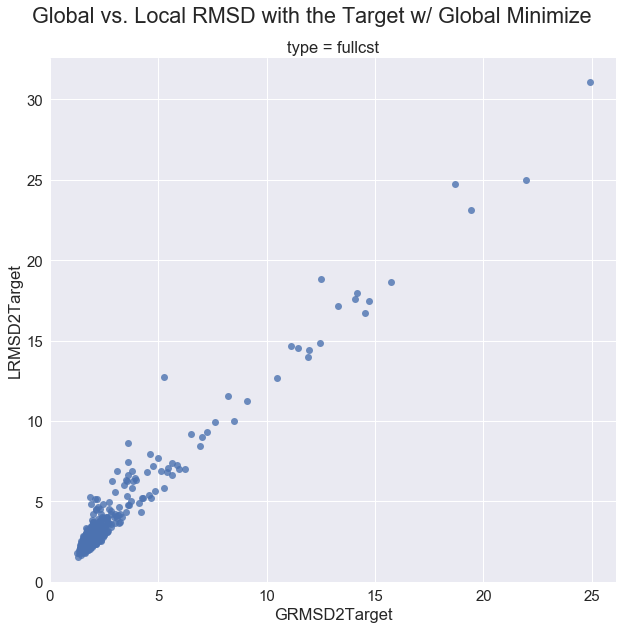

In [12]:
binderdataMIN = dataMIN[(dataMIN["condition"] == "binder")]
g = sns.FacetGrid(binderdataMIN, col="type", size=9)
g = g.map(sns.regplot, "GRMSD2Target", "LRMSD2Target", fit_reg=False)
plt.subplots_adjust(top=0.9)
g.axes[0,0].set_ylim(0,)
g.axes[0,0].set_xlim(0,)
g.fig.suptitle('Global vs. Local RMSD with the Target w/ Global Minimize')
sns.plt.show()

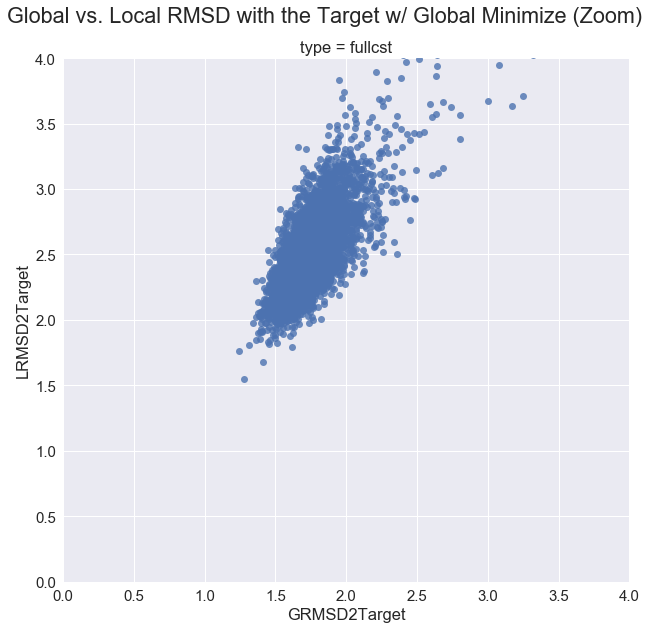

In [14]:
binderdataMIN = dataMIN[(dataMIN["condition"] == "binder")]
g = sns.FacetGrid(binderdataMIN, col="type", size=9)
g = g.map(sns.regplot, "GRMSD2Target", "LRMSD2Target", fit_reg=False)
plt.subplots_adjust(top=0.9)
g.axes[0,0].set_ylim(0,4)
g.axes[0,0].set_xlim(0,4)
g.fig.suptitle('Global vs. Local RMSD with the Target w/ Global Minimize (Zoom)')
sns.plt.show()

In [20]:
experiments = [
    ("fullcst", "minimized", "bcl2/fullcst/bcl2_fullcst_binder_from4oyd_minimize_5_minisilent.gz"),
    ("fullcst", "standard", "bcl2/fullcst/bcl2_fullcst_binder_from4oyd_3_minisilent.gz")
]
definition = {
    "scores":{
        "description": "description", "design_type": "type", "design_score": "score", "time": "time"
    }
}
dataframes     = []
for experiment in experiments:
    dlist      = rstoolbox.api.read_rosetta_silent(experiment[2], experiment[0])
    df         = rstoolbox.api.process_from_definitions(dlist, definition)
    df = df.assign(condition=pd.Series([experiment[1]]*len(df["type"])).values)
    dataframes.append(df)
    
dataTIME  = pd.concat(dataframes)

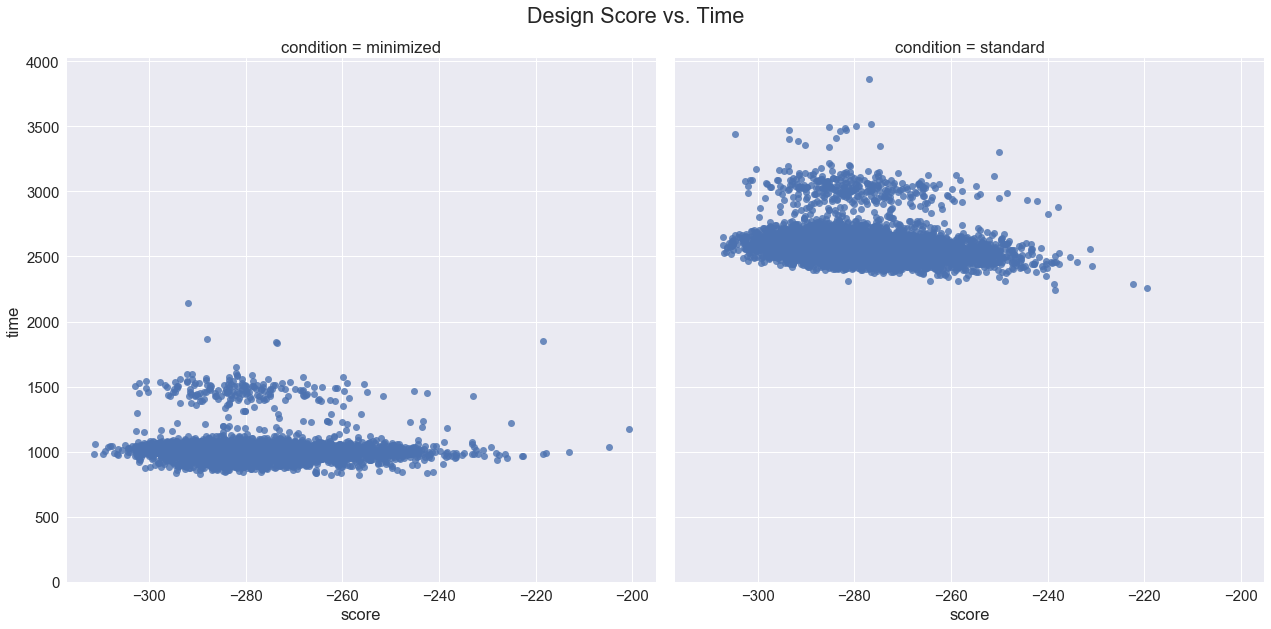

In [19]:
binderdataTIME = dataTIME[(dataTIME["type"] == "fullcst")]
g = sns.FacetGrid(binderdataTIME, col="condition", size=9)
g = g.map(sns.regplot, "score", "time", fit_reg=False)
plt.subplots_adjust(top=0.9)
g.axes[0,0].set_ylim(0,)
#g.axes[0,0].set_xlim(,0)
g.fig.suptitle('Design Score vs. Time')
sns.plt.show()